In [ ]:
import torch
import json
import os
import matplotlib.pyplot as plt
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
)
from datasets import load_dataset, concatenate_datasets
from peft import LoraConfig, get_peft_model, PeftModel
from tqdm import tqdm
import warnings
from torch.utils.data import DataLoader
from torch.optim import AdamW

In [ ]:
# Suppress warnings
warnings.filterwarnings("ignore")

# --- 1. Configuration ---
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
HOTPOT_DATASET_NAME = "hotpot_qa"
HOTPOT_DATASET_CONFIG = "distractor"
MATH_DATASET_NAME = "qwedsacf/competition_math"
RESULTS_DIR = "./drive/MyDrive/"

# --- VRAM-Saving Config ---
MAX_SEQ_LENGTH = 2048
PER_DEVICE_BS = 16 # This will be the batch size for *each* task's DataLoader
GRAD_ACC_STEPS = 1 # Kept for consistency, but manual loop handles 1 step at a time

# --- Experiment Config ---
N_TRAIN_EXAMPLES = 4000
N_VAL_EXAMPLES = 400
LEARNING_RATE = 2e-4       # Using the rate from the original Task A / Joint training
INTERLEAVE_EPOCHS = 2      # Doubled epochs (was 2 in baseline)
LOGGING_STEPS = 24         # Evaluate every 10 *batches* (e.g., 5 MATH, 5 HotpotQA)

In [ ]:
# --- 2. Utility Functions (Data Formatting - Llama Chat Style) ---
def format_hotpot_qa(example):
    """Formats HotpotQA data into a Llama-chat-style prompt."""
    context = " ".join(["".join(s) for s in example["context"]["sentences"]])
    question = example["question"]
    answer = example["answer"]

    text = (
        f"<s>[INST] You are a helpful assistant. Use the following context to "
        f"answer the question. Context: {context}\n\nQuestion: {question} [/INST] "
        f"Answer: {answer}</s>"
    )
    return text

def format_math(example):
    """Formats MATH data into a Llama-chat-style prompt."""
    problem = example["problem"]
    solution = example["solution"]

    text = (
        f"<s>[INST] You are a math expert. Solve the following math problem. "
        f"Show your work.\nProblem: {problem} [/INST] "
        f"Solution: {solution}</s>"
    )
    return text

def filter_by_length(example, tokenizer, formatter):
    """
    Filters out examples that are too long.
    Returns True (keep) or False (discard).
    """
    text = formatter(example)
    tokenized = tokenizer(text, max_length=MAX_SEQ_LENGTH + 1, truncation=False, padding=False)
    return len(tokenized['input_ids']) <= MAX_SEQ_LENGTH

def preprocess(example, tokenizer, formatter):
    """
    Formats text, applies loss mask, and pads to max length.
    """
    text = formatter(example)
    tokenized = tokenizer(
        text,
        max_length=MAX_SEQ_LENGTH,
        truncation=True,
        padding="max_length", # Pad to max length
    )
    labels = tokenized["input_ids"].copy()
    inst_token_id = tokenizer.convert_tokens_to_ids("]")

    # Find the end of the prompt (the ']' token)
    split_point = -1
    for i in range(len(tokenized["input_ids"]) - 1, -1, -1):
        if tokenized["input_ids"][i] == inst_token_id:
            split_point = i + 1
            break

    if split_point == -1:
        # If prompt format is not found, discard the example
        return {}

    # Mask out the prompt tokens (set to -100)
    for i in range(split_point):
        labels[i] = -100

    tokenized["labels"] = labels
    return tokenized

In [ ]:
# --- 3. Model Loading (Restructured) ---

def get_model_and_tokenizer_base():
    """
    Loads the base FP16 TinyLlama model and tokenizer.
    """
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.bfloat16, # Load in FP16 to save RAM
        device_map="auto",
        trust_remote_code=True,
    )
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    # Enable gradient checkpointing on the base model
    model.gradient_checkpointing_enable()

    return model, tokenizer

def get_lora_config():
    """
    Defines the LoRA configuration.
    """
    return LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=[
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
        ],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )

def manual_evaluate(model, dataloader, device):
    """
    Manually runs evaluation on a given dataloader.
    """
    model.eval()  # <-- Set to evaluation mode
    total_loss = 0
    total_steps = 0
    with torch.no_grad(): # <-- Disable gradient calculation
        for batch in dataloader:
            # Move batch to the same device as the model
            batch = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "labels"]}
            with torch.cuda.amp.autocast(dtype=torch.bfloat16):
              outputs = model(**batch)
              loss = outputs.loss

            total_loss += loss.item()
            total_steps += 1

    model.train() # <-- [Important] Set model back to training mode
    if total_steps == 0:
        return 0.0
    return total_loss / total_steps

In [ ]:
# --- 4. Main Experiment Logic ---
def main():
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)

    print(f"--- Loading Base Model & Tokenizer ---")
    base_model, tokenizer = get_model_and_tokenizer_base()

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    # --- Load and Process Datasets ---
    print(f"\n--- Loading and Preprocessing Datasets (This may take a while) ---")

    # Task B: HotpotQA
    raw_hotpot = load_dataset(HOTPOT_DATASET_NAME, HOTPOT_DATASET_CONFIG)
    hotpot_train = raw_hotpot["train"].shuffle(seed=42).select(range(N_TRAIN_EXAMPLES))
    hotpot_val = raw_hotpot["validation"].shuffle(seed=42).select(range(N_VAL_EXAMPLES))

    # Get original column names to remove them after mapping
    hotpot_train_cols = hotpot_train.column_names
    hotpot_val_cols = hotpot_val.column_names

    print(f"Tokenizing and filtering HotpotQA...")
    hotpot_train_tokenized = hotpot_train.filter(
        lambda x: filter_by_length(x, tokenizer, format_hotpot_qa),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_hotpot_qa),
        batched=False,
        remove_columns=hotpot_train_cols  # <-- [FIX] Remove original columns
    ).filter(lambda example: len(example) > 0) # Filter out failed preprocesses

    hotpot_val_tokenized = hotpot_val.filter(
        lambda x: filter_by_length(x, tokenizer, format_hotpot_qa),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_hotpot_qa),
        batched=False,
        remove_columns=hotpot_val_cols # <-- [FIX] Remove original columns
    ).filter(lambda example: len(example) > 0)

    print(f"HotpotQA: {len(hotpot_train_tokenized)} train, {len(hotpot_val_tokenized)} val (after filtering)")

    # Task A: MATH
    raw_math = load_dataset(MATH_DATASET_NAME)
    total_math_samples_needed = N_TRAIN_EXAMPLES + N_VAL_EXAMPLES
    math_subset = raw_math["train"].shuffle(seed=42).select(range(total_math_samples_needed))
    val_size_fraction = N_VAL_EXAMPLES / total_math_samples_needed
    math_splits = math_subset.train_test_split(test_size=val_size_fraction, seed=42)
    math_train = math_splits["train"]
    math_val = math_splits["test"]

    # Get original column names to remove them after mapping
    math_train_cols = math_train.column_names
    math_val_cols = math_val.column_names

    print(f"Tokenizing and filtering MATH...")
    math_train_tokenized = math_train.filter(
        lambda x: filter_by_length(x, tokenizer, format_math),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_math),
        batched=False,
        remove_columns=math_train_cols # <-- [FIX] Remove original columns
    ).filter(lambda example: len(example) > 0)

    math_val_tokenized = math_val.filter(
        lambda x: filter_by_length(x, tokenizer, format_math),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_math),
        batched=False,
        remove_columns=math_val_cols # <-- [FIX] Remove original columns
    ).filter(lambda example: len(example) > 0)

    print(f"MATH: {len(math_train_tokenized)} train, {len(math_val_tokenized)} val (after filtering)")

    # --- Setup for Manual Interleaved Training ---
    print(f"\n--- Setting up for Interleaved Training ---")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Get LoRA model
    lora_config = get_lora_config()
    model = get_peft_model(base_model, lora_config)
    model.print_trainable_parameters()
    # model.to(device) # device_map="auto" already handled this
    model.train() # Set to training mode

    # Create DataLoaders
    math_train_loader = DataLoader(
        math_train_tokenized,
        batch_size=PER_DEVICE_BS,
        collate_fn=data_collator,
        shuffle=True
    )
    hotpot_train_loader = DataLoader(
        hotpot_train_tokenized,
        batch_size=PER_DEVICE_BS,
        collate_fn=data_collator,
        shuffle=True
    )
    math_val_loader = DataLoader(
        math_val_tokenized,
        batch_size=PER_DEVICE_BS,
        collate_fn=data_collator
    )
    hotpot_val_loader = DataLoader(
        hotpot_val_tokenized,
        batch_size=PER_DEVICE_BS,
        collate_fn=data_collator
    )

    # Setup optimizer
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

    # History tracking
    history = {"steps": [], "hotpot_loss": [], "math_loss": []}
    global_step = 0

    # --- Initial Evaluation (Step 0) ---
    print("\n--- Running initial evaluation (Step 0) ---")
    hotpot_loss_0 = manual_evaluate(model, hotpot_val_loader, device)
    math_loss_0 = manual_evaluate(model, math_val_loader, device)

    history["steps"].append(0)
    history["hotpot_loss"].append(hotpot_loss_0)
    history["math_loss"].append(math_loss_0)
    print(f"  > Step 0 - HotpotQA Val Loss: {hotpot_loss_0:.4f}")
    print(f"  > Step 0 - MATH Val Loss: {math_loss_0:.4f}")

    # --- Start Interleaved Training Loop ---
    print(f"\n--- Starting Interleaved Training for {INTERLEAVE_EPOCHS} epochs ---")

    for epoch in range(INTERLEAVE_EPOCHS):
        print(f"\n--- Starting Epoch {epoch + 1}/{INTERLEAVE_EPOCHS} ---")
        model.train()

        # Create iterators for both datasets
        math_iter = iter(math_train_loader)
        hotpot_iter = iter(hotpot_train_loader)

        # We loop for the number of batches in the *smaller* dataset
        num_batches = min(len(math_train_loader), len(hotpot_train_loader))

        for i in tqdm(range(num_batches), desc=f"Epoch {epoch + 1}"):

            # --- Task A (MATH) Batch ---
            try:
                math_batch = next(math_iter)
            except StopIteration:
                # Should not happen with this loop structure, but as a safeguard
                math_iter = iter(math_train_loader)
                math_batch = next(math_iter)

            math_batch = {k: v.to(device) for k, v in math_batch.items() if k in ["input_ids", "attention_mask", "labels"]}
            with torch.cuda.amp.autocast(dtype=torch.bfloat16):
                outputs_math = model(**math_batch)
                loss_math = outputs_math.loss

            loss_math.backward()
            optimizer.step()
            optimizer.zero_grad()

            global_step += 1 # Increment global step after *each* batch

            # --- Log if needed ---
            if global_step % LOGGING_STEPS == 0:
                print(f"\n--- Evaluation at Step {global_step} (after MATH batch) ---")
                hotpot_loss = manual_evaluate(model, hotpot_val_loader, device)
                math_loss = manual_evaluate(model, math_val_loader, device)
                history["steps"].append(global_step)
                history["hotpot_loss"].append(hotpot_loss)
                history["math_loss"].append(math_loss)
                print(f"  > Step {global_step} - HotpotQA Val Loss: {hotpot_loss:.4f}")
                print(f"  > Step {global_step} - MATH Val Loss: {math_loss:.4f}")
                model.train() # Ensure model is back in train mode

            # --- Task B (HotpotQA) Batch ---
            try:
                hotpot_batch = next(hotpot_iter)
            except StopIteration:
                hotpot_iter = iter(hotpot_train_loader)
                hotpot_batch = next(hotpot_iter)

            hotpot_batch = {k: v.to(device) for k, v in hotpot_batch.items() if k in ["input_ids", "attention_mask", "labels"]}
            with torch.cuda.amp.autocast(dtype=torch.bfloat16):
                outputs_hotpot = model(**hotpot_batch)
                loss_hotpot = outputs_hotpot.loss

            loss_hotpot.backward()
            optimizer.step()
            optimizer.zero_grad()

            global_step += 1 # Increment global step again

            # --- Log if needed ---
            if global_step % LOGGING_STEPS == 0:
                print(f"\n--- Evaluation at Step {global_step} (after HotpotQA batch) ---")
                hotpot_loss = manual_evaluate(model, hotpot_val_loader, device)
                math_loss = manual_evaluate(model, math_val_loader, device)
                history["steps"].append(global_step)
                history["hotpot_loss"].append(hotpot_loss)
                history["math_loss"].append(math_loss)
                print(f"  > Step {global_step} - HotpotQA Val Loss: {hotpot_loss:.4f}")
                print(f"  > Step {global_step} - MATH Val Loss: {math_loss:.4f}")
                model.train() # Ensure model is back in train mode

    # --- 5. Plot Results ---
    print("\n--- Training Complete. Saving History Data and Generating Plot ---")

    # --- Save history data to JSON ---
    history_filename = os.path.join(RESULTS_DIR, "interleave_history_MATH_and_HotpotQA_fp32.json")
    try:
        with open(history_filename, 'w') as f:
            json.dump(history, f, indent=4)
        print(f"History data saved to {history_filename}")
    except Exception as e:
        print(f"Error saving history to JSON: {e}")
    # --- [END] ---

    plt.figure(figsize=(12, 6))
    plt.plot(history["steps"], history["hotpot_loss"], 'o-', label="Task B (HotpotQA) Loss", color="blue")
    plt.plot(history["steps"], history["math_loss"], 'o-', label="Task A (MATH) Loss", color="red")

    plt.title(f"Interleaved Training: MATH + HotpotQA (Model: {MODEL_NAME} FP32 LoRA)")
    plt.xlabel(f"Training Steps (Total Batches) (Total Epochs: {INTERLEAVE_EPOCHS})")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()

    plot_filename = os.path.join(RESULTS_DIR, "interleave_curve_MATH_and_HotpotQA_fp32.png")
    plt.savefig(plot_filename)
    print(f"Plot saved to {plot_filename}")

    try:
        from google.colab import files
        plt.show()
    except ImportError:
        print("Not in Colab, plot saved to file.")

INFO: Running on GPU. VRAM: 42.47 GB
--- Loading Base Model & Tokenizer ---


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]


--- Loading and Preprocessing Datasets (This may take a while) ---


README.md: 0.00B [00:00, ?B/s]

distractor/train-00000-of-00002.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

distractor/train-00001-of-00002.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

distractor/validation-00000-of-00001.par(…):   0%|          | 0.00/27.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Tokenizing and filtering HotpotQA...


Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3686 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3686 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/367 [00:00<?, ? examples/s]

HotpotQA: 3686 train, 367 val (after filtering)


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-7320a6f3aba8eb(…):   0%|          | 0.00/4.85M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12500 [00:00<?, ? examples/s]

Tokenizing and filtering MATH...


Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3994 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Filter:   0%|          | 0/399 [00:00<?, ? examples/s]

MATH: 3994 train, 399 val (after filtering)

--- Setting up for Interleaved Training ---
trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044

--- Running initial evaluation (Step 0) ---
  > Step 0 - HotpotQA Val Loss: 1.8873
  > Step 0 - MATH Val Loss: 1.5755

--- Starting Interleaved Training for 2 epochs ---

--- Starting Epoch 1/2 ---


Epoch 1:   5%|▍         | 11/231 [01:02<20:54,  5.70s/it]


--- Evaluation at Step 24 (after HotpotQA batch) ---


Epoch 1:   5%|▌         | 12/231 [01:48<1:05:51, 18.04s/it]

  > Step 24 - HotpotQA Val Loss: 1.8052
  > Step 24 - MATH Val Loss: 1.1599


Epoch 1:  10%|▉         | 23/231 [02:51<20:36,  5.94s/it]


--- Evaluation at Step 48 (after HotpotQA batch) ---


Epoch 1:  10%|█         | 24/231 [03:37<1:02:17, 18.06s/it]

  > Step 48 - HotpotQA Val Loss: 1.7711
  > Step 48 - MATH Val Loss: 1.0880


Epoch 1:  15%|█▌        | 35/231 [04:40<19:25,  5.95s/it]


--- Evaluation at Step 72 (after HotpotQA batch) ---


Epoch 1:  16%|█▌        | 36/231 [05:26<58:40, 18.05s/it]

  > Step 72 - HotpotQA Val Loss: 1.7614
  > Step 72 - MATH Val Loss: 1.0616


Epoch 1:  20%|██        | 47/231 [06:28<18:14,  5.95s/it]


--- Evaluation at Step 96 (after HotpotQA batch) ---


Epoch 1:  21%|██        | 48/231 [07:15<55:03, 18.05s/it]

  > Step 96 - HotpotQA Val Loss: 1.7560
  > Step 96 - MATH Val Loss: 1.0439


Epoch 1:  26%|██▌       | 59/231 [08:17<17:03,  5.95s/it]


--- Evaluation at Step 120 (after HotpotQA batch) ---


Epoch 1:  26%|██▌       | 60/231 [09:03<51:26, 18.05s/it]

  > Step 120 - HotpotQA Val Loss: 1.7521
  > Step 120 - MATH Val Loss: 1.0313


Epoch 1:  31%|███       | 71/231 [10:06<15:51,  5.95s/it]


--- Evaluation at Step 144 (after HotpotQA batch) ---


Epoch 1:  31%|███       | 72/231 [10:52<47:50, 18.06s/it]

  > Step 144 - HotpotQA Val Loss: 1.7494
  > Step 144 - MATH Val Loss: 1.0213


Epoch 1:  36%|███▌      | 83/231 [11:54<14:40,  5.95s/it]


--- Evaluation at Step 168 (after HotpotQA batch) ---


Epoch 1:  36%|███▋      | 84/231 [12:41<44:13, 18.05s/it]

  > Step 168 - HotpotQA Val Loss: 1.7475
  > Step 168 - MATH Val Loss: 1.0155


Epoch 1:  41%|████      | 95/231 [13:43<13:28,  5.95s/it]


--- Evaluation at Step 192 (after HotpotQA batch) ---


Epoch 1:  42%|████▏     | 96/231 [14:29<40:37, 18.05s/it]

  > Step 192 - HotpotQA Val Loss: 1.7453
  > Step 192 - MATH Val Loss: 1.0086


Epoch 1:  46%|████▋     | 107/231 [15:32<12:17,  5.95s/it]


--- Evaluation at Step 216 (after HotpotQA batch) ---


Epoch 1:  47%|████▋     | 108/231 [16:18<37:01, 18.06s/it]

  > Step 216 - HotpotQA Val Loss: 1.7435
  > Step 216 - MATH Val Loss: 1.0033


Epoch 1:  52%|█████▏    | 119/231 [17:20<11:06,  5.95s/it]


--- Evaluation at Step 240 (after HotpotQA batch) ---


Epoch 1:  52%|█████▏    | 120/231 [18:07<33:24, 18.06s/it]

  > Step 240 - HotpotQA Val Loss: 1.7423
  > Step 240 - MATH Val Loss: 0.9982


Epoch 1:  57%|█████▋    | 131/231 [19:09<09:54,  5.95s/it]


--- Evaluation at Step 264 (after HotpotQA batch) ---


Epoch 1:  57%|█████▋    | 132/231 [19:55<29:47, 18.06s/it]

  > Step 264 - HotpotQA Val Loss: 1.7412
  > Step 264 - MATH Val Loss: 0.9946


Epoch 1:  62%|██████▏   | 143/231 [20:58<08:43,  5.95s/it]


--- Evaluation at Step 288 (after HotpotQA batch) ---


Epoch 1:  62%|██████▏   | 144/231 [21:44<26:10, 18.06s/it]

  > Step 288 - HotpotQA Val Loss: 1.7395
  > Step 288 - MATH Val Loss: 0.9911


Epoch 1:  67%|██████▋   | 155/231 [22:46<07:32,  5.95s/it]


--- Evaluation at Step 312 (after HotpotQA batch) ---


Epoch 1:  68%|██████▊   | 156/231 [23:33<22:34, 18.06s/it]

  > Step 312 - HotpotQA Val Loss: 1.7386
  > Step 312 - MATH Val Loss: 0.9880


Epoch 1:  72%|███████▏  | 167/231 [24:35<06:20,  5.95s/it]


--- Evaluation at Step 336 (after HotpotQA batch) ---


Epoch 1:  73%|███████▎  | 168/231 [25:21<18:57, 18.05s/it]

  > Step 336 - HotpotQA Val Loss: 1.7380
  > Step 336 - MATH Val Loss: 0.9864


Epoch 1:  77%|███████▋  | 179/231 [26:24<05:09,  5.95s/it]


--- Evaluation at Step 360 (after HotpotQA batch) ---


Epoch 1:  78%|███████▊  | 180/231 [27:10<15:20, 18.05s/it]

  > Step 360 - HotpotQA Val Loss: 1.7370
  > Step 360 - MATH Val Loss: 0.9849


Epoch 1:  83%|████████▎ | 191/231 [28:13<03:57,  5.95s/it]


--- Evaluation at Step 384 (after HotpotQA batch) ---


Epoch 1:  83%|████████▎ | 192/231 [28:59<11:43, 18.05s/it]

  > Step 384 - HotpotQA Val Loss: 1.7360
  > Step 384 - MATH Val Loss: 0.9805


Epoch 1:  88%|████████▊ | 203/231 [30:01<02:46,  5.95s/it]


--- Evaluation at Step 408 (after HotpotQA batch) ---


Epoch 1:  88%|████████▊ | 204/231 [30:48<08:07, 18.04s/it]

  > Step 408 - HotpotQA Val Loss: 1.7357
  > Step 408 - MATH Val Loss: 0.9767


Epoch 1:  93%|█████████▎| 215/231 [31:50<01:35,  5.95s/it]


--- Evaluation at Step 432 (after HotpotQA batch) ---


Epoch 1:  94%|█████████▎| 216/231 [32:36<04:30, 18.05s/it]

  > Step 432 - HotpotQA Val Loss: 1.7347
  > Step 432 - MATH Val Loss: 0.9751


Epoch 1:  98%|█████████▊| 227/231 [33:39<00:23,  5.95s/it]


--- Evaluation at Step 456 (after HotpotQA batch) ---


Epoch 1:  99%|█████████▊| 228/231 [34:25<00:54, 18.05s/it]

  > Step 456 - HotpotQA Val Loss: 1.7342
  > Step 456 - MATH Val Loss: 0.9744


Epoch 1: 100%|██████████| 231/231 [34:40<00:00,  9.01s/it]



--- Starting Epoch 2/2 ---


Epoch 2:   3%|▎         | 8/231 [00:45<21:11,  5.70s/it]


--- Evaluation at Step 480 (after HotpotQA batch) ---


Epoch 2:   4%|▍         | 9/231 [01:31<1:08:05, 18.40s/it]

  > Step 480 - HotpotQA Val Loss: 1.7338
  > Step 480 - MATH Val Loss: 0.9724


Epoch 2:   9%|▊         | 20/231 [02:34<20:54,  5.95s/it]


--- Evaluation at Step 504 (after HotpotQA batch) ---


Epoch 2:   9%|▉         | 21/231 [03:20<1:03:13, 18.06s/it]

  > Step 504 - HotpotQA Val Loss: 1.7330
  > Step 504 - MATH Val Loss: 0.9727


Epoch 2:  14%|█▍        | 32/231 [04:22<19:43,  5.95s/it]


--- Evaluation at Step 528 (after HotpotQA batch) ---


Epoch 2:  14%|█▍        | 33/231 [05:09<59:33, 18.05s/it]

  > Step 528 - HotpotQA Val Loss: 1.7333
  > Step 528 - MATH Val Loss: 0.9699


Epoch 2:  19%|█▉        | 44/231 [06:11<18:32,  5.95s/it]


--- Evaluation at Step 552 (after HotpotQA batch) ---


Epoch 2:  19%|█▉        | 45/231 [06:57<55:58, 18.06s/it]

  > Step 552 - HotpotQA Val Loss: 1.7329
  > Step 552 - MATH Val Loss: 0.9686


Epoch 2:  24%|██▍       | 56/231 [08:00<17:21,  5.95s/it]


--- Evaluation at Step 576 (after HotpotQA batch) ---


Epoch 2:  25%|██▍       | 57/231 [08:46<52:22, 18.06s/it]

  > Step 576 - HotpotQA Val Loss: 1.7322
  > Step 576 - MATH Val Loss: 0.9644


Epoch 2:  29%|██▉       | 68/231 [09:48<16:09,  5.95s/it]


--- Evaluation at Step 600 (after HotpotQA batch) ---


Epoch 2:  30%|██▉       | 69/231 [10:35<48:44, 18.05s/it]

  > Step 600 - HotpotQA Val Loss: 1.7320
  > Step 600 - MATH Val Loss: 0.9626


Epoch 2:  35%|███▍      | 80/231 [11:37<14:58,  5.95s/it]


--- Evaluation at Step 624 (after HotpotQA batch) ---


Epoch 2:  35%|███▌      | 81/231 [12:23<45:07, 18.05s/it]

  > Step 624 - HotpotQA Val Loss: 1.7316
  > Step 624 - MATH Val Loss: 0.9624


Epoch 2:  40%|███▉      | 92/231 [13:26<13:47,  5.95s/it]


--- Evaluation at Step 648 (after HotpotQA batch) ---


Epoch 2:  40%|████      | 93/231 [14:12<41:31, 18.05s/it]

  > Step 648 - HotpotQA Val Loss: 1.7311
  > Step 648 - MATH Val Loss: 0.9614


Epoch 2:  45%|████▌     | 104/231 [15:15<12:35,  5.95s/it]


--- Evaluation at Step 672 (after HotpotQA batch) ---


Epoch 2:  45%|████▌     | 105/231 [16:01<37:54, 18.05s/it]

  > Step 672 - HotpotQA Val Loss: 1.7310
  > Step 672 - MATH Val Loss: 0.9599


Epoch 2:  50%|█████     | 116/231 [17:03<11:24,  5.95s/it]


--- Evaluation at Step 696 (after HotpotQA batch) ---


Epoch 2:  51%|█████     | 117/231 [17:50<34:18, 18.06s/it]

  > Step 696 - HotpotQA Val Loss: 1.7309
  > Step 696 - MATH Val Loss: 0.9580


Epoch 2:  55%|█████▌    | 128/231 [18:52<10:12,  5.95s/it]


--- Evaluation at Step 720 (after HotpotQA batch) ---


Epoch 2:  56%|█████▌    | 129/231 [19:38<30:41, 18.05s/it]

  > Step 720 - HotpotQA Val Loss: 1.7301
  > Step 720 - MATH Val Loss: 0.9558


Epoch 2:  61%|██████    | 140/231 [20:41<09:01,  5.95s/it]


--- Evaluation at Step 744 (after HotpotQA batch) ---


Epoch 2:  61%|██████    | 141/231 [21:27<27:04, 18.05s/it]

  > Step 744 - HotpotQA Val Loss: 1.7298
  > Step 744 - MATH Val Loss: 0.9551


Epoch 2:  66%|██████▌   | 152/231 [22:29<07:50,  5.95s/it]


--- Evaluation at Step 768 (after HotpotQA batch) ---


Epoch 2:  66%|██████▌   | 153/231 [23:16<23:28, 18.06s/it]

  > Step 768 - HotpotQA Val Loss: 1.7295
  > Step 768 - MATH Val Loss: 0.9544


Epoch 2:  71%|███████   | 164/231 [24:18<06:38,  5.95s/it]


--- Evaluation at Step 792 (after HotpotQA batch) ---


Epoch 2:  71%|███████▏  | 165/231 [25:04<19:51, 18.05s/it]

  > Step 792 - HotpotQA Val Loss: 1.7299
  > Step 792 - MATH Val Loss: 0.9532


Epoch 2:  76%|███████▌  | 176/231 [26:07<05:27,  5.95s/it]


--- Evaluation at Step 816 (after HotpotQA batch) ---


Epoch 2:  77%|███████▋  | 177/231 [26:53<16:14, 18.05s/it]

  > Step 816 - HotpotQA Val Loss: 1.7293
  > Step 816 - MATH Val Loss: 0.9522


Epoch 2:  81%|████████▏ | 188/231 [27:55<04:15,  5.95s/it]


--- Evaluation at Step 840 (after HotpotQA batch) ---


Epoch 2:  82%|████████▏ | 189/231 [28:42<12:38, 18.05s/it]

  > Step 840 - HotpotQA Val Loss: 1.7295
  > Step 840 - MATH Val Loss: 0.9495


Epoch 2:  87%|████████▋ | 200/231 [29:44<03:04,  5.95s/it]


--- Evaluation at Step 864 (after HotpotQA batch) ---


Epoch 2:  87%|████████▋ | 201/231 [30:30<09:01, 18.05s/it]

  > Step 864 - HotpotQA Val Loss: 1.7287
  > Step 864 - MATH Val Loss: 0.9487


Epoch 2:  92%|█████████▏| 212/231 [31:33<01:53,  5.95s/it]


--- Evaluation at Step 888 (after HotpotQA batch) ---


Epoch 2:  92%|█████████▏| 213/231 [32:19<05:24, 18.05s/it]

  > Step 888 - HotpotQA Val Loss: 1.7285
  > Step 888 - MATH Val Loss: 0.9483


Epoch 2:  97%|█████████▋| 224/231 [33:22<00:41,  5.95s/it]


--- Evaluation at Step 912 (after HotpotQA batch) ---


Epoch 2:  97%|█████████▋| 225/231 [34:08<01:48, 18.05s/it]

  > Step 912 - HotpotQA Val Loss: 1.7284
  > Step 912 - MATH Val Loss: 0.9466


Epoch 2: 100%|██████████| 231/231 [34:40<00:00,  9.01s/it]



--- Training Complete. Saving History Data and Generating Plot ---
History data saved to ./drive/MyDrive/interleave_history_MATH_and_HotpotQA_fp32.json
Plot saved to ./drive/MyDrive/interleave_curve_MATH_and_HotpotQA_fp32.png


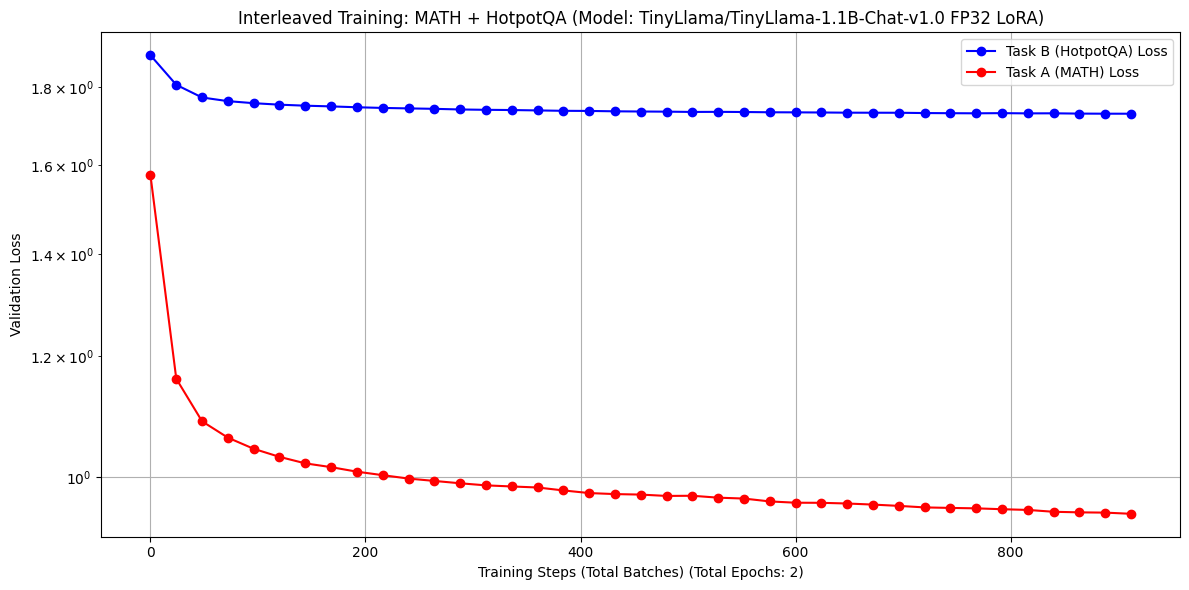

In [ ]:
if __name__ == "__main__":
    if not torch.cuda.is_available():
        print("ERROR: This experiment requires a GPU. Check Colab runtime type.")
    else:
        print(f"INFO: Running on GPU. VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        if torch.cuda.get_device_properties(0).total_memory / 1e9 < 11:
            print("WARNING: VRAM is less than 11GB. You may hit OOM errors. Try lowering MAX_SEQ_LENGTH.")
    main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
